# US Name

Estimate tangible asset as a function of  current ratio and others (Evaluate role of internal finance) 

# Business needs 

Estimate tangible asset as a function of  current ratio, cash_over_total_asset, liabilities over asset, Cash flow to total asset, cash flow to total tangible asset, credit constraint (Evaluate the impact of internal finance on asset) 

## Description
### Objective 

Test the coefficient sign and significant of the main variable

### Tables

Table 1: Baseline Estimate, tangible asset and current ratio, cash_over_total_asset, liabilities over asset, Cash flow to total asset, cash flow to total tangible asset, credit constraint

**Cautious**
Make sure no empty rows, otherwise it will be filtered out in the estimate


# Metadata

- Key: gac25vjvp54377n
- Epic: Models
- US: Internal finance estimate
- Task tag: #internal-finance, #credit-constraint, #firm-level
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name** 

- https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/09_asif_tfp_firm_baseline.md

**Github**

- DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/TFP/CREDIT_CONSTRAINT



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [5]:
change_target <- function(table){
    ## SOE
    check_target_current_ratio_soe <- grep("ownershipPRIVATE:log\\(current_ratio\\)", rownames(table$coef))
    check_target_liabilities_soe <- grep("ownershipPRIVATE:log\\(liabilities_tot_asset\\)", rownames(table$coef))
    ## foreign
    check_target_current_ratio_for <- grep("ownership_adjustedDOMESTIC:log\\(current_ratio\\)", rownames(table$coef))
    check_target_liabilities_for <- grep("ownership_adjustedDOMESTIC:log\\(liabilities_tot_asset\\)", rownames(table$coef))
    
    ## TCZ
    check_target_current_ratio_tcz <- grep("tcz:log\\(current_ratio\\)", rownames(table$coef))
    check_target_liabilities_tcz <- grep("tcz:log\\(liabilities_tot_asset\\)", rownames(table$coef))
    #check_target_cashflow_tcz <- grep("tcz:log\\(cashflow_to_tangible\\)", rownames(table$coef))
    
    ## SPZ
    check_target_current_ratio_spz <- grep("spz:log\\(current_ratio\\)", rownames(table$coef))
    check_target_liabilities_spz <- grep("spz:log\\(liabilities_tot_asset\\)", rownames(table$coef))
    #check_target_cashflow_spz <- grep("tcz:log\\(cashflow_to_tangible\\)", rownames(table$coef))
    
    if (length(check_target_current_ratio_soe) !=0) {
    ## SOE
    rownames(table$coefficients)[check_target_current_ratio_soe] <- 'log(current_ratio):ownershipPRIVATE'
    rownames(table$beta)[check_target_current_ratio_soe] <- 'log(current_ratio):ownershipPRIVATE'
    rownames(table$coefficients)[check_target_liabilities_soe] <- 'log(liabilities_tot_asset):ownershipPRIVATE'
    rownames(table$beta)[check_target_liabilities_soe] <- 'log(liabilities_tot_asset):ownershipPRIVATE'
    } else if (length(check_target_current_ratio_tcz) !=0){
    
    ## TCZ
    rownames(table$coefficients)[check_target_current_ratio_tcz] <- 'log(current_ratio):tcz'
    rownames(table$beta)[check_target_current_ratio_tcz] <- 'log(current_ratio):tcz'
    rownames(table$coefficients)[check_target_liabilities_tcz] <- 'log(liabilities_tot_asset):tcz'
    rownames(table$beta)[check_target_liabilities_tcz] <- 'log(liabilities_tot_asset):tcz'
    #rownames(table$coefficients)[check_target_cashflow_tcz] <- 'log(cashflow_to_tangible):tcz'
    #rownames(table$beta)[check_target_cashflow_tcz] <- 'log(cashflow_to_tangible):tcz'
        } else if (length(check_target_current_ratio_spz) !=0){
        
    ## SPZ
    rownames(table$coefficients)[check_target_current_ratio_spz] <- 'log(current_ratio):spz'
    rownames(table$beta)[check_target_current_ratio_spz] <- 'log(current_ratio):spz'
    rownames(table$coefficients)[check_target_liabilities_spz] <- 'log(liabilities_tot_asset):spz'
    rownames(table$beta)[check_target_liabilities_spz] <- 'log(liabilities_tot_asset):spz'
    #rownames(table$coefficients)[check_target_cashflow_spz] <- 'log(cashflow_to_tangible):tcz'
    #rownames(table$beta)[check_target_cashflow_spz] <- 'log(cashflow_to_tangible):tcz'
        }
    else if (length(check_target_current_ratio_for) !=0){
        
    ## for
    rownames(table$coefficients)[check_target_current_ratio_for] <- 'log(current_ratio):ownership_adjustedDOMESTIC'
    rownames(table$beta)[check_target_current_ratio_for] <- 'log(current_ratio):ownership_adjustedDOMESTIC'
    rownames(table$coefficients)[check_target_liabilities_for] <- 'log(liabilities_tot_asset):ownership_adjustedDOMESTIC'
    rownames(table$beta)[check_target_liabilities_for] <- 'log(liabilities_tot_asset):ownership_adjustedDOMESTIC'
    #rownames(table$coefficients)[check_target_cashflow_spz] <- 'log(cashflow_to_tangible):tcz'
    #rownames(table$beta)[check_target_cashflow_spz] <- 'log(cashflow_to_tangible):tcz'
        }
    return (table)
}

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

R has a hard time importing correctly values with many missing values, so to force R to import `rd_tot_asset` as a float, we use the following trick

- `rd_tot_asset` lowest value is -.013. Hence, when `rd_tot_asset` is missing replace by -1000

In [6]:
db = 'firms_survey'
table = 'asif_tfp_credit_constraint'

In [7]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [8]:
download_data = True
filename = 'df_{}_rd'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT *,
    CASE WHEN rd_tot_asset IS NULL THEN -1000 
    WHEN rd_tot_asset < 0 THEN 0
    ELSE rd_tot_asset END AS rd_tot_asset_trick
    FROM {}.{}
    WHERE
    cashflow_to_tangible > 0
    AND current_ratio > 0
    AND liabilities_tot_asset > 0
    AND age > 0
    AND year in (
        '2001', '2002', '2003', '2004', '2005', 
        '2006', '2007'
      )
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
          .assign(
              ownership = lambda x: np.where(x['ownership'].isin(['COLLECTIVE']), "SOE", x['ownership']),
          )
          .assign(
              ownership = lambda x: np.where(x['ownership'].isin(['HTM']), "FOREIGN", x['ownership']),
              ownership_adjusted = lambda x: np.where(x['ownership'].isin(['PRIVATE', 'SOE', 'COLLECTIVE']), 'DOMESTIC', 'FOREIGN'),
              fe_fo=lambda x: le.fit_transform(x["firm"].astype('str') + x['ownership'])
            )
        )
    #s3.download_file(
    #    key = full_path_filename
    #)
    #shutil.move(
    #    filename + '.csv',
    #    os.path.join(path_local, filename + '.csv')
    #)
    #s3.remove_file(full_path_filename)

In [9]:
df.to_csv(df_path, index = False)

In [10]:
pd.DataFrame(schema)

,Name,Type,Comment
0,firm,string,
1,year,string,
2,cic,string,
3,indu_2,string,
4,short,string,
5,geocode4_corr,string,
6,province_en,string,
7,tcz,string,
8,spz,string,
9,ownership,string,


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [11]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
        data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        ### depd
        {
        'old':'total\_asset',
        'new':'\\text{total asset}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{asset tangibility}'
        },
        
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'lag\_current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'lag\_liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'lag\_sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'lag\_cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'supply\_long\_term\_credit',
        'new':'\\text{long term credit}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit demand}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
        ## TFP
        {
        'old':'tfp\_cit',
        'new':'\\text{TFP}'
        },
        {
        'old':'ownershipPRIVATE',
        'new':'\\text{private}'
        },
        {
        'old':'ownership\_adjustedDOMESTIC',
        'new':'\\text{domestic}'
        }
        
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [12]:
import sys
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb

In [13]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [14]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
#    period = relevel(as.factor(period), ref='FALSE'),
    #soe_vs_pri = relevel(as.factor(soe_vs_pri), ref='SOE')
    ownership = relevel(as.factor(ownership), ref='SOE'),
    ownership_adjusted = relevel(as.factor(ownership_adjusted), ref='FOREIGN')
)
dim(df_final)

Parsed with column specification:
cols(
  .default = col_double(),
  short = col_character(),
  province_en = col_character(),
  ownership = col_character(),
  d_credit_constraint = col_character(),
  lag_current_ratio = col_logical(),
  lag_liabilities_tot_asset = col_logical(),
  lag_sales_tot_asset = col_logical(),
  rd_tot_asset = col_logical(),
  lag_cashflow_to_tangible = col_logical(),
  ownership_adjusted = col_character()
)
See spec(...) for full column specifications.


[1] 402369     56

In [15]:
glimpse(df_final)

Observations: 402,369
Variables: 56
$ firm                        <dbl> 310141, 257061, 287248, 186580, 253769, 3…
$ year                        <dbl> 2001, 2001, 2001, 2001, 2001, 2001, 2001,…
$ cic                         <dbl> 2621, 1810, 2624, 1321, 1492, 1351, 3070,…
$ indu_2                      <dbl> 26, 18, 26, 13, 14, 13, 30, 31, 31, 20, 1…
$ short                       <fct> Raw Chemical Materials, Footwear, Raw Che…
$ geocode4_corr               <dbl> 6104, 3101, 4302, 3415, 2203, 1201, 4407,…
$ province_en                 <fct> Shaanxi, Shanghai, Hunan, Anhui, Jilin, T…
$ tcz                         <dbl> 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,…
$ spz                         <dbl> 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,…
$ ownership                   <fct> PRIVATE, PRIVATE, PRIVATE, PRIVATE, SOE, …
$ output                      <dbl> 238501, 35530, 86352, 6120, 69729, 31194,…
$ employment                  <dbl> 550, 810, 328, 95, 279, 103, 30, 120, 400…
$ capital       

## Table 1: Channel of transmission: Asset accumulation

$$
\begin{aligned}
\text { (Asset) }_{i t}= \beta_{1}\text {Cash flow}_{fit}+\beta_{2}\text {Current ratio}_{fit}+\beta_{3}\text {liabilities to asset}_{fit} + \beta_{4}\text {X}_{fit} +\epsilon_{fit}
\end{aligned}
$$

* Column 1: tangible to total asset
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`
* Column 2: RD to total asset
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`
        
**var of interest**

- `cashflow_to_tangible``
- `current_ratio`
- `liabilities_tot_asset`
        
**Control**

- `Sales/Assets` 
- `age`
- `export_to_sale` 


All explanatory variables are lagged one year.

In [16]:
folder = 'Tables_1'
table_nb = 10
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
try:
    for ext in ['table_{}.txt'.format(table_nb), 'table_{}.tex'.format(table_nb), 'table_{}.pdf'.format(table_nb)]:
        os.remove(os.path.join(folder, ext))
except:
    pass

Need to add `%>% filter(!is.na(labor_capital))` to have the same number of observartions as TFP table

In [17]:
%get path table
t_0 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | firm + year + indu_2|0 | firm,df_final%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

t_1 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | firm + year + indu_2|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007"))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

## All credits
t_2 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_all_credit
            | firm + year + indu_2|0 | firm,df_final%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

#t_3 <- felm(rd_tot_asset_trick ~
#            log(cashflow_to_tangible) +
#            log(current_ratio) +
#            log(liabilities_tot_asset) +
#            log(age) +
#            export_to_sale +
#            supply_all_credit
#            |firm + year + indu_2|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007"))%>% filter(!is.na(labor_capital)),
#            exactDOF = TRUE)

## LT credit
t_3 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_long_term_credit
            | firm + year + indu_2|0 | firm,df_final,
            exactDOF = TRUE)

#t_5 <- felm(rd_tot_asset_trick ~
#            log(cashflow_to_tangible) +
#            log(current_ratio) +
#            log(liabilities_tot_asset) +
#            log(age) +
#            export_to_sale +
#            supply_long_term_credit
#            |firm + year + indu_2|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007"))%>% filter(!is.na(labor_capital)),
#            exactDOF = TRUE)
            
dep <- "Dependent variable"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "No", "Yes", "No"),
    c("industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3#, t_4, t_5
),
    title="Asset structure (tangible versus intangible) and internal finance",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

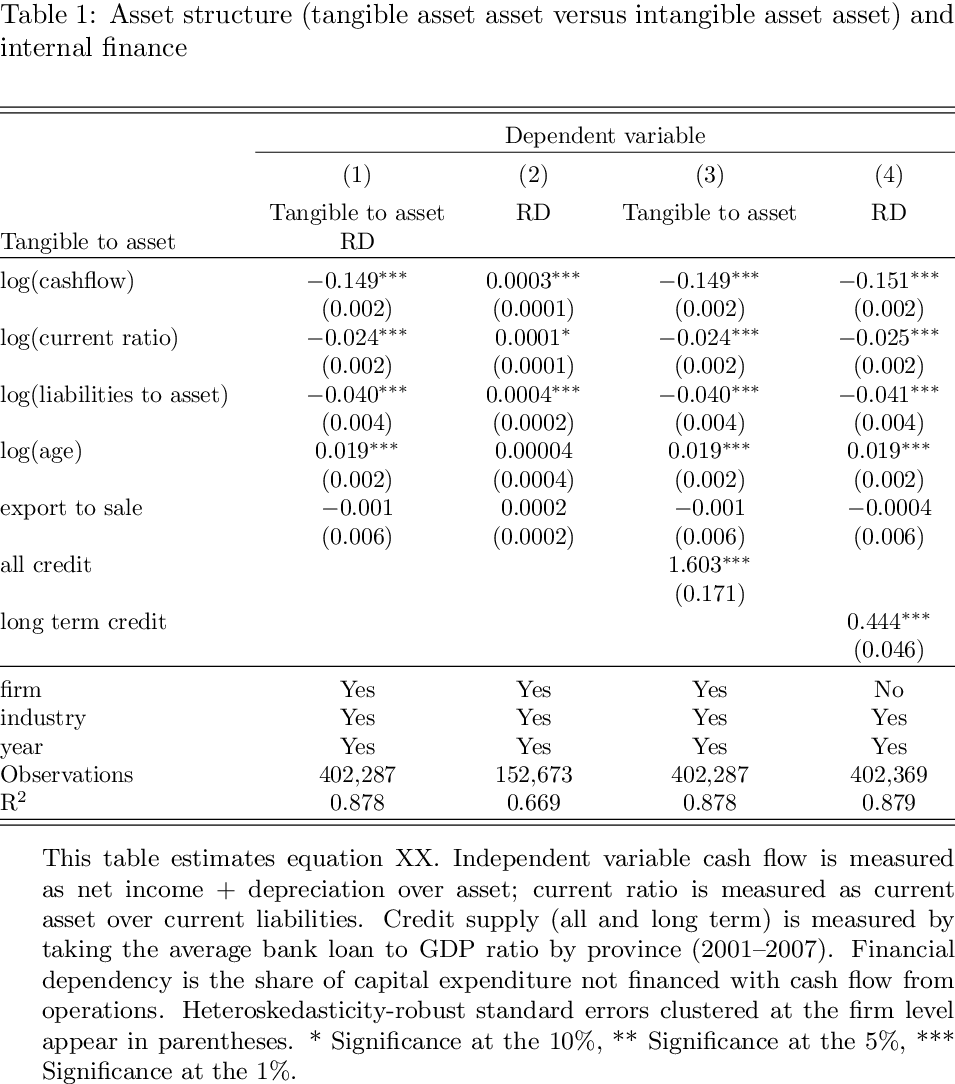

In [18]:
tbe1  = "This table estimates equation XX. " \
"Independent variable cash flow is measured as net income + depreciation over asset; " \
"current ratio is measured as current asset over current liabilities. " \
"Credit supply (all and long term) is measured by taking the average bank loan to GDP ratio by province (2001–2007). " \
"Financial dependency is the share of capital expenditure not financed with cash flow from operations. " \
"Heteroskedasticity-robust standard errors clustered at the firm level appear in parentheses. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%. " 

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Tangible to asset', 'RD', 'Tangible to asset', 'Tangible to asset']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

In [19]:
os.rename('Tables_1/{}.tex'.format(table), 'Tables_1/{}_ASSET.tex'.format(table))

## Table 2: Ownership structure effect

## SOE vs Private

Manually rename tex: table_11_SOE

In [20]:
folder = 'Tables_1'
table_nb = 11
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)

try:
    for ext in ['table_{}.txt'.format(table_nb), 'table_{}.tex'.format(table_nb), 'table_{}.pdf'.format(table_nb)]:
        os.remove(os.path.join(folder, ext))
except:
    pass

In [21]:
%get path table
t_0 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

t_1 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible)* ownership +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
                year %in% list("2005","2006", "2007") & 
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

t_2 <- felm(log(asset_tangibility_tot_asset) ~
            log(current_ratio) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
t_3 <- felm(rd_tot_asset_trick ~
            log(current_ratio) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
                year %in% list("2005","2006", "2007") & 
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
t_4 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership+
            log(current_ratio) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
t_5 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible)* ownership +
            log(current_ratio) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
                year %in% list("2005","2006", "2007") & 
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_5 <- change_target(t_5)

###
t_6 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership+
            log(current_ratio) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_all_credit
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
#t_7 <- felm(rd_tot_asset_trick ~
#            log(cashflow_to_tangible)* ownership +
#            log(current_ratio) * ownership+
#            log(liabilities_tot_asset) +
#           log(age) +
#            export_to_sale +
#            supply_all_credit
#            | fe_fo + year + indu_2|0 | firm,df_final %>%
#            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
#                year %in% list("2005","2006", "2007") & 
#            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
t_7 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership+
            log(current_ratio) * ownership+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_long_term_credit
            | fe_fo + year + indu_2|0 | firm,df_final %>%
            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_7 <- change_target(t_7)
#t_9 <- felm(rd_tot_asset_trick ~
#            log(cashflow_to_tangible)* ownership +
#           log(current_ratio) * ownership+
#            log(liabilities_tot_asset) +
#            log(age) +
#            export_to_sale +
#            supply_long_term_credit
#            | fe_fo + year + indu_2|0 | firm,df_final %>%
#            mutate(ownership = replace(ownership, ownership %in% c('FOREIGN', 'HTM'), 'PRIVATE'))%>% filter(
#                year %in% list("2005","2006", "2007") & 
#            ownership %in% c('SOE','PRIVATE'))%>% filter(!is.na(labor_capital)),
#            exactDOF = TRUE)
#t_9 <- change_target(t_9)

dep <- "Dependent variable"
fe1 <- list(
    c("firm-ownership", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5, t_6, t_7#, t_8, t_9
),
    title="Asset structure (tangible versus intangible) and internal finance",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 


Keyboard Interrupt


In [ ]:
tbe1  = "This table estimates eq(X). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear inparentheses."\
"Dependent variables include firm's TFP level " \
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

reorder = {
    7:1,
    8:3,
    #13:5
}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Tangible to asset', 'RD', 'Tangible to asset', 'RD', 'Tangible to asset', 'RD',
        'Tangible to asset', 'Tangible to asset']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

In [ ]:
os.rename('Tables_1/{}.tex'.format(table), 'Tables_1/{}_SOE.tex'.format(table))

## Domestic vs Foreign

- table_13_DOMESTIC.tex

In [ ]:
folder = 'Tables_1'
table_nb = 13
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)

try:
    for ext in ['table_{}.txt'.format(table_nb), 'table_{}.tex'.format(table_nb), 'table_{}.pdf'.format(table_nb)]:
        os.remove(os.path.join(folder, ext))
except:
    pass

In [ ]:
%get path table
t_0 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

t_1 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible)* ownership_adjusted +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)

t_2 <- felm(log(asset_tangibility_tot_asset) ~
            log(current_ratio) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
t_3 <- felm(rd_tot_asset_trick ~
            log(current_ratio) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
t_4 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership_adjusted+
            log(current_ratio) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
t_5 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible)* ownership_adjusted +
            log(current_ratio) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_5 <- change_target(t_5)

###
t_6 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership_adjusted+
            log(current_ratio) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_all_credit
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
#t_7 <- felm(rd_tot_asset_trick ~
#            log(cashflow_to_tangible)* ownership_adjusted +
#            log(current_ratio) * ownership_adjusted+
#            log(liabilities_tot_asset) +
#            log(age) +
#            export_to_sale +
#            supply_all_credit
#            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
#            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
t_7 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) * ownership_adjusted+
            log(current_ratio) * ownership_adjusted+
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_long_term_credit
            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
            ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
            exactDOF = TRUE)
t_8 <- change_target(t_8)
#t_9 <- felm(rd_tot_asset_trick ~
#            log(cashflow_to_tangible)* ownership_adjusted +
#            log(current_ratio) * ownership_adjusted+
#            log(liabilities_tot_asset) +
#            log(age) +
#            export_to_sale +
#            supply_long_term_credit
#            | fe_fo + year + indu_2|0 | firm,df_final %>% filter(
#           ownership_adjusted %in% c('DOMESTIC','FOREIGN'))%>% filter(!is.na(labor_capital)),
#            exactDOF = TRUE)
#t_9 <- change_target(t_9)

dep <- "Dependent variable"
fe1 <- list(
    c("firm-ownership", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0, t_1, t_2, t_3, t_4,t_5, t_6, t_7#, t_8, t_9
),
    title="Asset structure (tangible versus intangible) and internal finance",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 


In [ ]:
tbe1  = "This table estimates eq(X). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear inparentheses."\
"Dependent variables include firm's TFP level " \
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'DOMESTIC': 2,
    'FOREIGN': 2,
}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Tangible to asset', 'RD', 'Tangible to asset', 'RD', 'Tangible to asset', 'RD',
        'Tangible to asset', 'Tangible to asset']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

In [ ]:
os.rename('Tables_1/{}.tex'.format(table), 'Tables_1/{}_DOMESTIC.tex'.format(table))

In [ ]:
import glob
for ext in ['*.txt', '*.pdf']:
    for zippath in glob.iglob(os.path.join(folder, ext)):
        os.remove(zippath)

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = True, notebookname = "06_internal_finance_firm_level.ipynb")